In [22]:
import numpy as np
import math

import requests as req

from sgp4.api import Satrec, jday

import skyfield.sgp4lib as sgp4lib
from skyfield import api

from datetime import datetime, timedelta
import pytz

import matplotlib.pyplot as plt
from dateutil import rrule
from operator import itemgetter

In [23]:
def latLonToEcef(lat, lon, alt):
    a = 6378137.0
    b = 6356752.3142
    
    rad_lat = np.deg2rad(lat)
    rad_lon = np.deg2rad(lon)
    
    N = a ** 2 / np.sqrt(a ** 2 * np.cos(rad_lat) ** 2 + b ** 2 * np.sin(rad_lat) ** 2)
    
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (b ** 2 / a ** 2 * N + alt) * np.sin(rad_lat)
    
    return x, y, z

In [24]:
lk_lat = 55.930195540685304
lk_lon = 37.5182925079981
lk_alt = 193
x, y, z = latLonToEcef(lk_lat, lk_lon, lk_alt)

In [25]:
x, y, z

(2840612.5584051693, 2181119.9165616864, 5260252.075030604)

In [26]:
import pygeodesy
karney = pygeodesy.ecef.EcefKarney(a_ellipsoid=pygeodesy.Ellipsoids.WGS84)

ref = karney.forward(lk_lat, lk_lon, lk_alt)
x, y, z = latLonToEcef(lk_lat, lk_lon, lk_alt)

assert(np.linalg.norm([ref.x - x, ref.y - y, ref.z - z]) < 1)

In [27]:
class SatTracker:
    def __init__(self, norad_id):
        
        # Get most recent TLE data from celestrak
        r = req.get('https://celestrak.com/satcat/tle.php?CATNR={}'.format(norad_id))
        text = r.text
        print(text)
        lines = text.split('\r\n')
        self.s = lines[1]
        self.t = lines[2]
        self.satellite = Satrec.twoline2rv(self.s, self.t)

    def latLonToEcef(self, lat, lon, alt):
        a = 6378137.0
        b = 6356752.3142

        rad_lat = np.deg2rad(lat)
        rad_lon = np.deg2rad(lon)

        N = a ** 2 / np.sqrt(a ** 2 * np.cos(rad_lat) ** 2 + b ** 2 * np.sin(rad_lat) ** 2)

        x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
        y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
        z = (b ** 2 / a ** 2 * N + alt) * np.sin(rad_lat)

        return x, y, z
    
    def siteSatVec(self, satpos, sitepos):
        return np.array(satpos) - np.array(sitepos)
    
    def getSiteSatVec(self, lla, time):
        # Local time to UTC
        local_time = datetime(time[0], time[1], time[2], time[3], time[4], time[5])
        utc_time = local_time.astimezone(pytz.UTC)

        # Site coords in ECEF
        x, y, z = self.latLonToEcef(lla[0], lla[1], lla[2])

        # Julian date from UTC
        ts = api.load.timescale()
        jd = ts.tt(utc_time.year, utc_time.month, utc_time.day,
                   utc_time.hour, utc_time.minute, utc_time.second).tdb

        # Coords and speeds in TEME frame
        satellite = Satrec.twoline2rv(self.s, self.t)        
        e, r, v = satellite.sgp4(jd, 0.0)

        v = np.array(v) * 24.0 * 60.0 * 60.0  # km/s to km/day

        # Convert TEME(ECI) to ECEF
        rITRF, _ = sgp4lib.TEME_to_ITRF(jd, np.array(r), np.array(v))

        return self.siteSatVec(rITRF * 1000, [x, y, z])
    
    def ecefDispToEnu(self, disp, lla):
        # https://www.ngs.noaa.gov/CORS/Articles/SolerEisemannJSE.pdf
        phi = math.radians(lla[0])
        lamb = math.radians(lla[1])
        
        sin_lambda = math.sin(lamb)
        cos_lambda = math.cos(lamb)
        sin_phi = math.sin(phi)
        cos_phi = math.cos(phi)
        
        e = -sin_phi * disp[0] + cos_phi * disp[1]
        n = -sin_phi * cos_lambda * disp[0] - sin_lambda * sin_phi * disp[1] + cos_phi * disp[2]
        u = cos_lambda * cos_phi * disp[0] + cos_phi * sin_lambda * disp[1] + sin_phi * disp[2]
        return e, n, u
        
    def enuToAzimElev(self, enu):
        return math.atan2(enu[0], enu[1]), math.atan(enu[2] / math.sqrt(enu[1] ** 2 + enu[0] ** 2))
    
    def getSatLookAngles(self, lla, time, unit="deg"):
        satSiteVec = self.getSiteSatVec(lla, time)
        
        enu = self.ecefDispToEnu(satSiteVec, lla)
        
        a, v = self.enuToAzimElev(enu)
        
        if unit == "rad":
            return a, v
        
        return math.degrees(a), math.degrees(v)
    
    def findIntercepts(self, lla, start_date, end_date, rule=rrule.MINUTELY, plot=True):
        dates = [dt for dt in rrule.rrule(rule, dtstart=start_date, until=end_date)]

        intercepts = []
        is_visible = False
        cur = {}
        for date in dates:
            az, el = self.getSatLookAngles([lla[0], lla[1], lla[2]],
                                         [date.year, date.month, date.day,
                                          date.hour, date.minute, date.second])
            
            if not is_visible:
                if el > 0:
                    cur = {}
                    is_visible = True
                    cur['start_time'] = date
                    cur['start_azim'] = az
                    cur['points'] = []
                    cur['points'].append({'time': date, 'az': az, 'el': el})
            else:
                if el > 0:
                    cur['points'].append({'time': date, 'az': az, 'el': el})
                else:
                    is_visible = False
                    cur['end_time'] = date
                    cur['end_azim'] = az
                    cur['points'].append({'time': date, 'az': az, 'el': el})
                    cur['max_alt'] = max(cur['points'], key=itemgetter('el'))
                    
                    intercepts.append(cur)
        
        if plot:
            fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
            for inter in intercepts:
                azims = [x['az'] for x in inter['points']]
                elevs = [x['el'] for x in inter['points']]
                
                ax.plot(np.deg2rad(np.array(azims)), np.array(elevs),
                        label='From {} to {}'.format(inter['start_time'], inter['end_time']))
                
            ax.set_theta_zero_location("N")
            ax.set_theta_direction(-1)
            ax.set_rticks([0, 30, 60, 90])
            ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

            plt.ylim(90, 0)
            ax.grid(True)
            plt.show() 
            
        return intercepts

In [28]:
norad_id = 28654
tr = SatTracker(norad_id)

NOAA 18                 
1 28654U 05018A   21329.15689951  .00000088  00000-0  71538-4 0  9994
2 28654  98.9763  34.5167 0014312 185.0636 175.0393 14.12660176851225



In [29]:
az, al = tr.getSatLookAngles([lk_lat, lk_lon, lk_alt], [2021, 11, 25, 14, 5, 0])
print(az, al)

-24.650715929670863 13.247970087875512


In [30]:
start_date = datetime(2021, 11, 25, 13, 30, 0)
end_date = datetime(2021, 11, 25, 16, 0, 0)

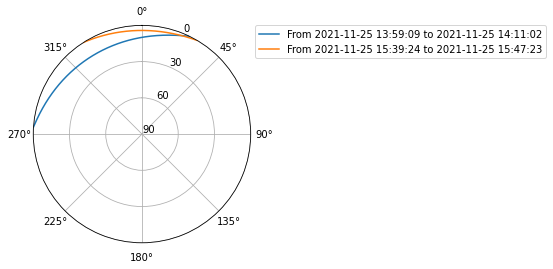

In [31]:
intercepts = tr.findIntercepts([lk_lat, lk_lon, lk_alt], start_date, end_date, rule=rrule.SECONDLY, plot=True)

In [32]:
for inter in intercepts:
    print(inter['max_alt'])

{'time': datetime.datetime(2021, 11, 25, 14, 5, 22), 'az': -29.6763932780962, 'el': 13.33938090435674}
{'time': datetime.datetime(2021, 11, 25, 15, 43, 39), 'az': 0.27466430698372035, 'el': 4.210066057584927}
